# Analysis of behavioral drift though a _linear_ regression approach 

__1. Define set of behavioral regressors__

    "Bad Behavior"
    1. Velocity
    2. Position on patch  
    
    "Uninteresting Behavior"
    3. Reward size 
    4. Time on patch  
    
    "Good Behavior"
    5. Number of Rews  
    6. total uL received
    7. Time since reward  
    8. Reward above expected

__2. For every trial, collect data from time after last reward__ 
 - Fit regression between "time left on patch" and behavioral regressors
 - Ensure that fits are roughly equally good using R^2

__3. Analyze drift in linear regression model coefficients within session, across sessions__ 
- Are there discrete or slow changes in model fits that consistently vary across session? 
- Use Kalman filter to estimate gaussian walk if seems smooth 
- Assumption: changes in behavior are slow and consistent between reward sizes
    - Alternatively, could fit model coefficients per reward size 
    - But this will not be a good model of single trial lapses in performance

In [274]:
# standard stuff
import numpy as np  
import random
import scipy.io as sio  
import os 
import matplotlib.pyplot as plt 
import seaborn as sns   
import pandas as pd    
from scipy.stats import zscore
# sklearn stuff
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression,ElasticNet 
import scipy.optimize as optimize

## Prepare Datasets

In [3]:
# load all datasets into dictionary
mouse_dir = '/Users/joshstern/Documents/UchidaLab_NeuralData/processed_neuropix_data/all_mice'   
data = dict()

with os.scandir(mouse_dir) as it:
    for entry in it:
        if not entry.name.startswith('.') and entry.is_file():
            data[entry.name[:2] + entry.name[-7:-4]] = sio.loadmat(entry.path) 
            print("Finished loading %s"%entry.name)


Finished loading 79_20200225.mat
Finished loading 76_20200305.mat
Finished loading 79_20200226.mat
Finished loading 76_20200306.mat
Finished loading 76_20200307.mat
Finished loading 79_20200227.mat
Finished loading 76_20200303.mat
Finished loading 76_20200302.mat
Finished loading 80_20200315.mat
Finished loading 80_20200317.mat
Finished loading 79_20200304.mat
Finished loading 79_20200305.mat
Finished loading 80_20200316.mat
Finished loading 78_20200312.mat
Finished loading 78_20200313.mat
Finished loading 78_20200311.mat
Finished loading 79_20200302.mat
Finished loading 79_20200303.mat
Finished loading 78_20200310.mat
Finished loading 75_20200313.mat
Finished loading 79_20200229.mat
Finished loading 76_20200309.mat
Finished loading 75_20200315.mat
Finished loading 76_20200308.mat
Finished loading 79_20200228.mat


In [286]:
flatten = lambda l: [item for sublist in l for item in sublist]  

def expo_cdf(dt,N0 = .25,tau = .125):
    """
        Assign reward delivery probabilities according to scaled Expo decay
    """
    x = np.arange(0,50,dt)
    cdf = 1 - N0 * np.exp(-tau * x) / tau + N0 / tau  
    return np.array(cdf)

# superclass 
class Dataset():
    def __init__(self,data,pre_leave_buffer_ms): 
        self.data = data  
        self.pre_leave_buffer_ms = pre_leave_buffer_ms
        
    def gen_trialedDataset(self,data): 
        """  
            Arguments 
                data: dataset from one session

            Returns
                X_trials: array of nTrials matrices of taskvars 
                    Velocity 
                    Position on patch 
                    Rewsize 
                    Time on Patch 
                    # Rewards 
                    Total uL 
                    Time since reward 
                y_trials: array of nTrials vectors of time to leave from after last reward
        """   
        # timebin
        tbin_ms = 1000 * data['velt'][0][1] - data['velt'][0][0]     
        dt = tbin_ms / 1000

        # session timing timing information
        patchCSL = data['patchCSL'] 
        rewsizes = data['patches'][:,1] % 10
        nTrials = patchCSL.shape[0]
        patchstop_ms = patchCSL[:,1] * 1000   
        patchleave_ms = patchCSL[:,2] * 1000  
        prts = patchleave_ms - patchstop_ms 
        rew_ms = data['rew_ts'] * 1000  
        # create index vectors from our timing information vector and labeling settings
        patchstop_ix = np.round(patchstop_ms / tbin_ms).astype(int)
        patchleave_ix = np.round((patchleave_ms - self.pre_leave_buffer_ms) / tbin_ms).astype(int) 
        
        # Collect behavioral variables
        vel_trials = [data['vel'][0][patchstop_ix[iTrial]:patchleave_ix[iTrial]] for iTrial in range(nTrials)]
        pos_trials = [data['patch_pos'][0][patchstop_ix[iTrial]:patchleave_ix[iTrial]] for iTrial in range(nTrials)]
        t_lens = [len(v) for v in vel_trials]  
        round_prts = np.array(t_lens) * tbin_ms / 1000 # prt rounded to nearest dt   
        
        avg_cdf = expo_cdf(dt)
        
        # Collect task variables and combine w/ behavioral variables
        X_trials = [] # task variables put together in an array 
        y_trials = [] # label data as on patch or leave patch 
        last_rew_ix = np.zeros(nTrials,dtype = np.int64) # collect last rew indices to cut down matrices in a second
        for iTrial in range(nTrials): 
            # get the reward timing for this trial (excludes t = 0 reward)
            rew_indices = np.round((rew_ms[(rew_ms > patchstop_ms[iTrial]) & (rew_ms < patchleave_ms[iTrial])] - patchstop_ms[iTrial]) / 1000)
            last_rew_ix[iTrial] = int(np.round(np.max(np.insert(rew_indices,0,0)) * 1000 / tbin_ms)) 
            
            # time on patch ... and handling of off-by-one errors
            if len(np.arange(0,round_prts[iTrial],dt)) == t_lens[iTrial]:
                tr_timeOnPatch = np.arange(0,round_prts[iTrial],dt) 
            elif len(np.arange(0,round_prts[iTrial],dt)) == t_lens[iTrial] + 1:   
                if len(np.arange(0,round_prts[iTrial]-dt,dt)) == t_lens[iTrial]: 
                    tr_timeOnPatch = np.arange(0,round_prts[iTrial]-dt,dt)  
                else: 
                    tr_timeOnPatch = np.arange(0,round_prts[iTrial]-dt/2,dt)  
            elif len(np.arange(0,round_prts[iTrial],dt)) == t_lens[iTrial] - 1: 
                if len(np.arange(0,round_prts[iTrial]+dt,dt)) == t_lens[iTrial]: 
                    tr_timeOnPatch = np.arange(0,round_prts[iTrial]+dt,dt)  
                else: 
                    tr_timeOnPatch = np.arange(0,round_prts[iTrial]+dt/2,dt)   
            else: 
                print("We are off by more than one in indexing somehow") 

            # some reward-related signals 
            tr_rewsize = np.full(len(tr_timeOnPatch),rewsizes[iTrial]) 
            tr_timesince = tr_timeOnPatch.copy()
            tr_rewCount = np.zeros(len(tr_timeOnPatch))
            tr_uLtotal = np.zeros(len(tr_timeOnPatch)) 
            pre_rew_label = np.zeros(t_lens[iTrial])  
            for i,rew_sec in enumerate(rew_indices):    
                # add to timesince 
                irew_ix = int(round(rew_sec * 1000 /tbin_ms))  
                irew_msec = rew_sec * 1000
                try:
                    tr_timesince[irew_ix:] = np.arange(0,round_prts[iTrial]-rew_sec,dt)     
                except:   
                    tr_timesince[irew_ix:] = np.arange(0,round_prts[iTrial]-rew_sec-dt/2,dt)  

                # update reward and uL count
                tr_rewCount[irew_ix:] = i + 1 
                tr_uLtotal[irew_ix:] = (i + 1) * rewsizes[iTrial]  
            
            tr_rewOverExp = (1 + tr_rewCount) - avg_cdf[:len(tr_rewCount)]
            
            # now add to data structures
            tr_X = np.concatenate((vel_trials[iTrial][:,np.newaxis],
                                   pos_trials[iTrial][:,np.newaxis],
                                   tr_timeOnPatch[:,np.newaxis], 
                                   tr_rewsize[:,np.newaxis],
                                   tr_timesince[:,np.newaxis],
                                   tr_rewCount[:,np.newaxis],
                                   tr_uLtotal[:,np.newaxis], 
                                   tr_rewOverExp[:,np.newaxis]),axis = 1)  
            X_trials.append(tr_X)
            
            tr_y = tr_timeOnPatch[::-1]
            y_trials.append(tr_y) 
        
        X_trials_postRew = [X_trials[iTrial][last_rew_ix[iTrial]:,:] for iTrial in range(nTrials)]
        y_trials_postRew = [y_trials[iTrial][last_rew_ix[iTrial]:]   for iTrial in range(nTrials)]
            
        return X_trials,y_trials,X_trials_postRew,y_trials_postRew
    
    def train_val_split(self,X_trials,y_trials,rewsizes):  
        """ 
            Function to split training and validation data 
            On all trials or a subset of trials
        """ 
        tmp_nTrials = len(y_trials)
        
        # vector with every index labeled by its trial number
        trial_ix = np.array(flatten([[iTrial] * len(y_trials[iTrial]) for iTrial in range(tmp_nTrials)]))
        # allocate training and validation trials 
        train_trials = [] 
        val_trials = []
        for rewsize in [1,2,4]: 
            iRewsize_trials = np.where(rewsizes == rewsize)[0]  
            i_train_trials = random.sample(list(iRewsize_trials),k = int(self.prop_val*len(iRewsize_trials)))  
            i_val_trials = np.setdiff1d(iRewsize_trials,i_train_trials)
            train_trials.append(i_train_trials) 
            val_trials.append(i_val_trials.tolist())   
        # flatten our lists of lists to make list of trials
        train_trials = np.array(flatten(train_trials))
        val_trials = np.array(flatten(val_trials)) 
        train_ix = np.where(np.isin(trial_ix,train_trials)) 
        val_ix = np.where(np.isin(trial_ix,val_trials)) 
        # convert to size of train trials
        train_trial_ix = trial_ix[train_ix]
        
        # Now turn separated data into arrays
        X_train = np.concatenate([X_trials[trial] for trial in train_trials])
        y_train = np.concatenate([y_trials[trial] for trial in train_trials])
        X_val = np.concatenate([X_trials[trial] for trial in val_trials]) 
        y_val = np.concatenate([y_trials[trial] for trial in val_trials])  
        
        # Now divide training data into k folds, first at the trial level
        trial_folds = np.empty(tmp_nTrials) 
        trial_folds[:] = np.nan 
        trial_folds[val_trials] = -1 # set aside the validation trials 
        for shift,iRewsize in enumerate(np.unique(self.rewsizes)):  
            iRewsize_train_trials = train_trials[np.where(rewsizes[np.array(train_trials)] == iRewsize)] 
            iRewsize_folds = np.tile(range(self.k),tmp_nTrials)[:len(iRewsize_train_trials)] 
            iRewsize_folds = (iRewsize_folds + shift*len(np.unique(rewsizes))) % (self.k) # shift s.t. we don't skimp on the last fold
            trial_folds[iRewsize_train_trials] = iRewsize_folds 
        self.trial_folds = trial_folds

        # Now turn our trials into k length list of [(train_index, test_index)]   
        kfold_split = []
        for test_fold in range(self.k):   
            fold_train_trials = np.where((self.trial_folds >= 0) & (self.trial_folds != test_fold))[0]
            fold_test_trials = np.where(self.trial_folds == test_fold)[0] 
            fold_train_ix = np.where(np.isin(train_trial_ix,fold_train_trials))[0] 
            fold_test_ix = np.where(np.isin(train_trial_ix,fold_test_trials))[0] 
            kfold_split.append((fold_train_ix,fold_test_ix))  
        
        return (X_train,y_train,kfold_split,X_val,y_val)
    
    def fit_model_cv(self,model,X,y,kfold_split,dropout_ix = []): 
        """
            Train an Sklearn linear model on trialed X and y data  
            
            Arguments: 
                X_trialed (Potentially for some range of trials) 
                y_trialed (Potentially for some range of trials)
            
            Returns:  
                cv_results_dict
        """      
        coeffs = np.zeros((X.shape[1],self.k))
        test_rmse = np.zeros(self.k) 
        
        for f,(train_index, test_index) in enumerate(kfold_split):    
            # make new regression pipeline
            pipeline = make_pipeline(StandardScaler(),model)
            
            # split data by fold
            fold_X_train, fold_X_test = X[train_index], X[test_index]
            fold_y_train, fold_y_test = y[train_index], y[test_index]  

            # train models on their different datasets
            pipeline = pipeline.fit(fold_X_train, fold_y_train)  
            
            fold_y_pred = pipeline.predict(fold_X_test) 
            test_rmse[f] = np.sqrt(metrics.mean_squared_error(fold_y_test, fold_y_pred)) 
            coeffs[:,f] = pipeline[1].coef_
        
        cv_fit_results_dict = dict(test_rmse = test_rmse, 
                                   coeffs = coeffs)
        return cv_fit_results_dict 
    
    def fit_elasticNet_cv(self,alpha,l1_ratio): 
        """ 
            Train elasticnet regression to optimize for hyperparameters w.r.t. test set rmse
        """   
        elasticnet = ElasticNet(alpha = alpha,l1_ratio = l1_ratio) 
        results_dict = session_data.fit_model_cv(elasticnet,self.X_train,self.y_train,self.kfold_split) 
        
        return np.mean(results_dict['test_rmse']) 
    
    def dropout_test(self,X,y,kfold_split):  
        """ 
            Train a logistic regression model on trialed X and y data to analyze variables that improve ll
        
            
            Arguments:  
                X_trialed (Potentially for some range of trials) 
                y_trialed (Potentially for some range of trials) 
                kfold_split: kfold xval index tuples 
            
            Return: 

        """
        raise NotImplemented 

class MouseDataset(Dataset): 
    def __init__(self,data,mouse,pre_leave_buffer_ms): 
        self.pre_leave_buffer_ms = pre_leave_buffer_ms
        
        mouse_days = [day for day in list(data.keys()) if mouse in day] # find all mouse days 
        sorted_mouse_days = list(map(str,np.sort([int(day) for day in mouse_days]))) 
        self.data = {mouse_day: data[mouse_day] for mouse_day in sorted_mouse_days} # subselect mouse data 
        tbin_ms = self.data[mouse_days[0]]['velt'][0][1] - self.data[mouse_days[0]]['velt'][0][0]
        
class SessionDataset(Dataset): 
    def __init__(self,data,day,pre_leave_buffer_ms,k = 5,prop_val = 0.9): 
        self.data = data[day] # subselect session data     
        self.rewsizes = self.data['patches'][:,1] % 10 
        self.nTrials = len(self.rewsizes) 
        self.k = k 
        self.prop_val = prop_val 
        self.pre_leave_buffer_ms = pre_leave_buffer_ms
        
        # make regression dataset 
        (self.X_trials,
         self.y_trials,
         self.X_trials_postRew,
         self.y_trials_postRew) = self.gen_trialedDataset(self.data)    
        
        # split data into train and validation sets, training set into k folds
        (self.X_train,self.y_train,
         self.kfold_split,
         self.X_val,self.y_val) = self.train_val_split(self.X_trials_postRew,self.y_trials_postRew,self.rewsizes)
        
        self.alpha_optimized,self.l1_ratio_optimized = optimize_elasticNet_params(self)
        
class SubSessionDataset(Dataset): 
    def __init__(self,data,day,pre_leave_buffer_ms,window_len,window_stride,k = 5,prop_val = .9): 
        self.data = data[day] # subselect session data 
        self.rewsizes = self.data['patches'][:,1] % 10 
        self.nTrials = len(self.rewsizes) 
        self.k = k 
        self.prop_val = prop_val 
        self.pre_leave_buffer_ms = pre_leave_buffer_ms
        
        # make classification dataset
        (self.X_trials,
         self.y_trials,
         self.X_trials_postRew,
         self.y_trials_postRew) = self.gen_trialedDataset(self.data)     
        
        # split data into kfold train and val sets over windows
        nTrials = len(self.y_trials)
        # now make training and validation datasets per window of session  
        self.window_starts = np.arange(0,nTrials - window_len,window_stride)   
        self.window_ends = self.window_starts + window_len
        self.X_train = [] 
        self.y_train = [] 
        self.kfold_split = [] 
        self.X_val = [] 
        self.y_val = []  
        for (start,end) in zip(self.window_starts,self.window_ends): 
            trials = np.arange(start,end-1)    
            (X_train,y_train,
             kfold_split,
             X_val,y_val) = self.train_val_split(np.array(self.X_trials_postRew)[trials],
                                                 np.array(self.y_trials_postRew)[trials],
                                                 self.rewsizes[trials]) 
            self.X_train.append(X_train) 
            self.y_train.append(y_train) 
            self.kfold_split.append(kfold_split) 
            self.X_val.append(X_val) 
            self.y_val.append(y_val)
    

In [279]:
# Elasticnet hyperparameter optimization methods 

def fit_elasticNet_cv(alpha_l1ratio,session_data): 
        """ 
            Train elasticnet regression to optimize for hyperparameters w.r.t. test set rmse
        """    
        elasticnet = ElasticNet(alpha = alpha_l1ratio[0],l1_ratio = alpha_l1ratio[1]) 
        results_dict = session_data.fit_model_cv(elasticnet,session_data.X_train,session_data.y_train,session_data.kfold_split) 
        
        return np.mean(results_dict['test_rmse'])   
    
def optimize_elasticNet_params(session_data): 
    """ 
        Scipy optimize.minimize call
    """
    x0 = (.5,.5) 
    bnds = [(.01,.99),(0.01,.99)] 
    alpha,l1_ratio = optimize.minimize(fit_elasticNet_cv,x0,(session_data),bounds = bnds)["x"]
    return alpha,l1_ratio


In [ ]:
# Visualization functions 
def vis_coeffs(coeffs,metrics_dict,session_title): 
    """ 
        Visualize Coefficients
    """  
    AP = np.mean(metrics_dict['ap']) 
    auROC = np.mean(metrics_dict['auc'])
    plt.figure()   
    black = [.4,.4,.4] 
    red = [0.8392156862745098, 0.15294117647058825, 0.1568627450980392]
    blue = [0.12156862745098039, 0.4666666666666667, 0.7058823529411765]
    colors = sns.color_palette([black,black,red,red,blue,blue,blue]) 
    sns.barplot(data = coeffs,palette = colors) 
    plt.xticks(np.arange(7),["Velocity","Position","Time on patch","Reward size","Time Since Reward","Reward Count","Total uL"],rotation = "vertical");

## Session Results 

In [296]:
pre_leave_buffer = 500
session_data = SessionDataset(data,"78310",pre_leave_buffer)   


In [297]:
elasticnet = ElasticNet(alpha = session_data.alpha_optimized,l1_ratio = session_data.l1_ratio_optimized) 
linreg = LinearRegression() 

linreg_results_dict = session_data.fit_model_cv(linreg,session_data.X_train,session_data.y_train,session_data.kfold_split) 
elastic_results_dict = session_data.fit_model_cv(elasticnet,session_data.X_train,session_data.y_train,session_data.kfold_split) 
print("Unregularized Test RMSE:",np.mean(linreg_results_dict['test_rmse']))
print("ElasticNet Test RMSE:",np.mean(elastic_results_dict['test_rmse']))


Unregularized Test RMSE: 6.813888231891445
ElasticNet Test RMSE: 6.6776047425128455


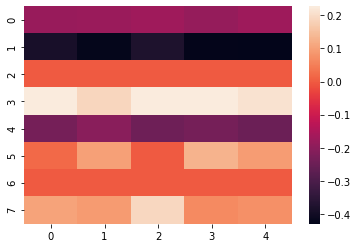

In [298]:
sns.heatmap(results_dict['coeffs'])

In [290]:
results_dict['test_rmse']

array([0.51643061, 0.54483701, 0.6434332 , 0.51403947, 0.48910329])

In [ ]:
def expo_cdf(dt,N0 = .25,tau = .125):
    """
        Assign reward delivery probabilities according to scaled Expo decay
    """
    x = np.arange(0,50,dt)
    cdf = 1 - N0 * np.exp(-tau * x) / tau + N0 / tau  
    return np.array(cdf)

plt.plot( - expo_cdf(.25,.125,.05))